<a href="https://colab.research.google.com/github/bkee06/IBM_Capstone/blob/main/Yelp_cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Data Science Capstone

This notebook contains content related to the final capstone project for IBM Applied Data Science. 

*Written by B Kee.* 

# Project Aim:
To analise the potential locations for drone delivery hubs based on proximity to playgrounds and subsequently select the highest rated Coffee Shop in each cluster to approach for a colaboration. 

# Datasets:

[Australian Government - Data.gov.au - ACT Playground Datasets.](https://data.gov.au/dataset/ds-actmapi-https%3A%2F%2Factmapi-actgov.opendata.arcgis.com%2Fdatasets%2F6baffe02451d47baa1c13626b21f43a8_6/details?q=act%20playgrounds)

# API's:

[Yelp - Web Data API Documentation](https://www.yelp.com/fusion)



In [3]:
# Import all appropriate and required Libraries for the project. 

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you want to use conda rather then pip
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt # plotting library

# backend for rendering plots within the browser
%matplotlib inline 

# import k-means for clustering
import sklearn
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you want to use conda rather then pip
!pip install folium
import folium # map rendering library

!pip install yelpapi
from yelpapi import YelpAPI
#import argparse
#from pprint import pprint

#!conda install geopandas # uncomment this line if you want to use conda rather then pip
!pip install geopandas
import geopandas as gpd

#!conda install -c conda-forge geopandas # uncomment this line if you want to use conda rather then pip
#!pip install fiona

#!pip install -U kaleido
!pip install plotly
import plotly as pl
import plotly.express as px
#import kaleido

print('Libraries imported.')

Libraries imported.


In [7]:
yelp_api = YelpAPI('Rbb1rd7xyPjnDzJNyzrPIR1kna7yZTEGhV7vzX-gmR2fSt2LiFPcYjbDZUWL42mRPLcS3SSfjtOo36Uri6dQIQS6GAerhkCLcGupJVxumGMmxYO27royRAJaUxu_YHYx')


# Before we get started:

Please run the small app below to find the highest rated Coffee shop near you! :)


In [8]:

address = input("Firstly, before we get started please enter your location name (City, Country): ")

geolocator = Nominatim(user_agent="my_agent")
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude

#print(longitude1, latitude1)

response = yelp_api.search_query(term='coffee', latitude = {latitude1}, longitude = {longitude1},radius = 3000, sort_by='rating', limit=1)

shop_json = response['businesses']
shop_df = pd.json_normalize(shop_json)
shop_df = shop_df.rename(columns={'location.display_address': 'address'})

shop = shop_df.name[0] 
shop_location = shop_df.address[0]

print('You should get a coffee from: {} at {} before reading my Capstone Project! :)\n'.format(shop, shop_location))


Firstly, before we get started please enter your location name (City, Country): Canberra
You should get a coffee from: The Cupping Room at ['Shop 1', '#1', 'Canberra Australia Capital Territory 2601', 'Australia'] before reading my Capstone Project! :)



# Import Data for Playground Location:

A dataset is provided by the Australian Government of all playgrounds in the Australian Capital Territory. This can be accessed in a variety of formats. The shapefile will be used as it provides the easiest means to produce a single lat/long for each location. 

In [9]:
# Assign url's to the appropriate datasets. 
url_geojson = 'https://actmapi-actgov.opendata.arcgis.com/datasets/4bc2ae2b59eb40d99130f5b5b0505abf_7.geojson?outSR=%7B%22latestWkid%22%3A28355%2C%22wkid%22%3A28355%7D'
url_csv = 'https://actmapi-actgov.opendata.arcgis.com/datasets/4bc2ae2b59eb40d99130f5b5b0505abf_7.csv?outSR=%7B%22latestWkid%22%3A28355%2C%22wkid%22%3A28355%7D'
url_shape = 'https://actmapi-actgov.opendata.arcgis.com/datasets/6baffe02451d47baa1c13626b21f43a8_6.zip?outSR=%7B%22latestWkid%22%3A28355%2C%22wkid%22%3A28355%7D'


#playground_df = gpd.read_file(url_geojson) # uncomment to import data as a geojson
#playground_df = pd.read_csv(url_csv) # uncomment to import data as a csv

#import shapefile into a data frame named pg_shape
pg_shape = gpd.read_file(url_shape)

# Check the data was imported by inspecting the head of the dataframe
pg_shape.head()

,PLAYAREA_I,IAMS_ID,PARENT_PLA,PARENT_P_1,DIVISION_N,UPGRADE_YE,EQUIPMENT_,SURFACE_TY,SURFACE_LO,SURFACE_AR,OTHER_SURF,OTHER_SU_1,OTHER_SU_2,EDGING_TYP,FENCING_TY,ACCESS_DES,ALL_ACCESS,AGE_RANGE_,AGE_RANG_1,AGE_RANG_2,AGE_RANG_3,BALANCE,BRIDGE,BAR,CLIMBER,CUBBY,COMBINATIO,FLYING_FOX,FORT,GOAL,PANAL,ROCKER,ROTATION,SCULPTURE,SLIDE,SOUND,SWING,TRACK_GLID,SAND_ELEME,EXERCISE_E,VEHICLE,TOTAL_STRU,COMMENTS,FEATURE_TY,OPERATIONA,PERIMETER,LATITUDE,LONGITUDE,FEATURE__1,CREATE_DAT,FEATURE_IN,OBJECTID,NATURAL_EL,PLAYGROUND,OBJECTID_1,geometry
0,570,PLAR618,NEMERANG CRESCENT NEIGHBOURHOOD PLAYGROUND,PLGR502,WARAMANGA,2004.0,34000.0,TANBARK,NORTH EAST SUPPORT POST AT SLIDE,308,NONE,UNDERNEATH CRADLE SWING SEAT,NaN,TIMBER (SLEEPER),NONE,NO FOOTPATH,NO,YES,YES,YES,YES,0,1,0,0,0,1,0,0,0,0,2,0,0,0,0,1,0,0,0,0,5,"CONTAINS COMBINATION UNIT, POMMEL WALK BRIDGE,...",PLAY AREA,None,83.743705,None,None,20,2006-04-19,None,509,0,None,1,"POLYGON ((687495.810 6085385.177, 687496.139 6..."
1,88,PLAR291,TUGGERANONG TOWN DISTRICT PARK,PLGR242,GREENWAY,2000.0,20000.0,TANBARK,AT SOUTH EAST SUPPORT OF ROPE BRIDGE,189,NONE,AT CONVEX CLIMBER,NaN,CONCRETE,NONE,NO FOOTPATH,NO,NO,NO,NO,NO,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,CONTAINS SENIOR COMBINATION UNIT WITH WAVE CLI...,PLAY AREA,None,53.091511,None,None,20,2005-11-24,None,519,0,None,2,"POLYGON ((687523.621 6079403.764, 687523.542 6..."
2,84,PLAR286,LAKE TUGGERANONG CENTRAL COMMUNITY PLAYGROUND,PLGR240,GREENWAY,1985.0,93000.0,TANBARK,CENTRAL SPIRAL SLIDE SUPPORT POST,654,RUBBER,UNDER TYRE SWING SEAT,NaN,BRICK,NONE,GRAVEL FOOTPATH,NO,YES,YES,YES,YES,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,"CONTAINS COMBINATION UNIT, CAROUSEL, ROCKERS A...",PLAY AREA,None,105.055264,None,None,20,2005-11-24,None,530,0,None,3,"POLYGON ((688202.853 6080304.036, 688202.182 6..."
3,574,PLAR628,WESTON PARK DISTRICT PLAYGROUND (EAST),PLGR211,YARRALUMLA,2007.0,20000.0,TANBARK,BASE OF NORTH SUPPORT POST,374,NONE,UNDERNEATH NORTHEAST EDGE,NaN,CONCRETE,NONE,NO FOOTPATH,NO,NO,NO,NO,NO,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,CONTAINS SPACENET,PLAY AREA,None,69.832033,None,None,20,2008-03-03,None,539,0,None,4,"POLYGON ((689979.075 6092608.438, 689979.557 6..."
4,401,PLAR195,LYTTLETON CRESCENT NEIGHBOURHOOD PLAYGROUND,PLGR168,COOK,1985.0,8000.0,TANBARK,NORTH WEST SUPPORT POST OF SWING FRAME,167,NONE,UNDERNEATH EAST FLAT SWING SEAT,NaN,CONCRETE,NONE,NO FOOTPATH,NO,YES,YES,YES,YES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,CONTAINS SWING.,PLAY AREA,None,46.061747,None,None,20,2005-11-24,None,555,0,None,5,"POLYGON ((687791.824 6096071.457, 687793.366 6..."


# Clean and Prepare Data:

After importing the dataset from the shapefile we only need a small part of the data for this project. A new dataframe is created to contain just the ID, Name and 'geometry' of each playground. As the location of each playground is stored as a polygon of lat/longs and only a single lat/long for each playground is required for the project we can use the centroid function from the geopandas library to find a single lat/long for the centre of each polygon. This is then added to the dataframe and the geometry of the geodataframe is then set to the centroid column to allow the use of the plot() library function to provide a graphical representation. 

The Co-ordinate Refernce System (CRS) is then converted to WGS84 to allow the extraction of the lat/long later in the project and to display the values as a decimal. 

No further data cleaning was required as there are no null, nan, or blank fields in the data. 

[GeoPandas Documentation](https://geopandas.readthedocs.io/en/latest/docs/user_guide/data_structures.html#geodataframe)

In [10]:
# Clean the data set by creating new dataframe with just the relevant columns of interest
pg_ll = pd.DataFrame(pg_shape, columns = ['PLAYAREA_I', 'PARENT_PLA', 'geometry'])

# Convert the dataframe back to a geodataframe to ensure geopandas functions will work on the dataframe
pg_ll = gpd.GeoDataFrame(pg_ll, geometry='geometry')

# Use the geopandas function 'centroid' to find a single lat/long for each playground area (polygon) and add as a new column
pg_ll['centroid'] = pg_ll.centroid

# As pg_ll is a geodataframe set the column 'centroid' to be the reference for geometry data when plotting the dataset. 
pg_ll = pg_ll.set_geometry("centroid")

# The 'geometry' column is no longer needed.
pg_ll = pg_ll.drop(columns=['geometry'])

#record the old crs
old_crs = pg_ll.crs

# Convert the geodataframe to WGS84
pg_ll = pg_ll.to_crs(epsg=4326)

# Now split the lat/long from the centroid column into individual columns so they are represented as floats to allow later analysis
pg_ll['long'] = pg_ll['centroid'].x
pg_ll['lat'] = pg_ll['centroid'].y

print(pg_ll.head(), '\n')

   PLAYAREA_I                                     PARENT_PLA  \
0         570     NEMERANG CRESCENT NEIGHBOURHOOD PLAYGROUND   
1          88                 TUGGERANONG TOWN DISTRICT PARK   
2          84  LAKE TUGGERANONG CENTRAL COMMUNITY PLAYGROUND   
3         574         WESTON PARK DISTRICT PLAYGROUND (EAST)   
4         401    LYTTLETON CRESCENT NEIGHBOURHOOD PLAYGROUND   

                      centroid        long        lat  
0  POINT (149.06358 -35.35739)  149.063584 -35.357387  
1  POINT (149.06535 -35.41107)  149.065349 -35.411072  
2  POINT (149.07241 -35.40279)  149.072411 -35.402790  
3  POINT (149.08932 -35.29166)  149.089324 -35.291663  
4  POINT (149.06433 -35.26093)  149.064331 -35.260928   



Now lets have a look at the final dataset before using it for further analysis

In [11]:
print('The old CRS was: ', old_crs, '\n',)

print('The new CRS is : ', pg_ll.crs, '\n')

# Check the size of the dataset
print('The new dataset now has the shape: ', pg_ll.shape, '\n')

# Check the centroid values are displayed as appropriate lat/longs in a standard format. 
print('The first lat/longs are: Geometry = {}, Long = {}, Lat = {}' .format(pg_ll.centroid[0], pg_ll.long[0], pg_ll.lat[0]), '\n')

# Check the data types of the dataset
print('The data types are: \n', pg_ll.dtypes)

The old CRS was:  epsg:28355 

The new CRS is :  epsg:4326 

The new dataset now has the shape:  (703, 5) 

The first lat/longs are: Geometry = POINT (149.0635838115136 -35.35738671717123), Long = 149.06358381151355, Lat = -35.35738671717123 

The data types are: 
 PLAYAREA_I       int64
PARENT_PLA      object
centroid      geometry
long           float64
lat            float64
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




The data can also be visually represented to allow any clusters, trends or initial observations to be made. 

From this plot it can be seen there are about 5 main areas and the plot generally represents the populus areas of the region.

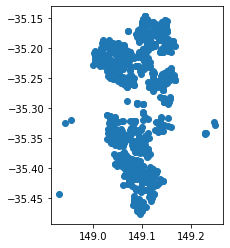

In [12]:
#Use the geopandas function plot() to show our geometry points 
pg_ll.plot()

# K-Means Cluster Analysis:

To allow a kmeans cluster grouping on our playgrouds locations we seperated the Lat/long into individual columns of the type float. This allows us to plot them as x,y co-ordinates. As can be seen this plot looks similar to the geopandas plot above. 

In [13]:

# clean the data to only contain the lat/long to use as x,y co-ordinates. 
pg_ll_only = pg_ll.drop(columns=['PLAYAREA_I', 'PARENT_PLA', 'centroid'])

fig = px.scatter(pg_ll_only, x="long", y="lat")

fig.update_layout(
    title = "Plot of Playgrounds in Canberra",
    width = 800,
    height = 600
)

fig.show()

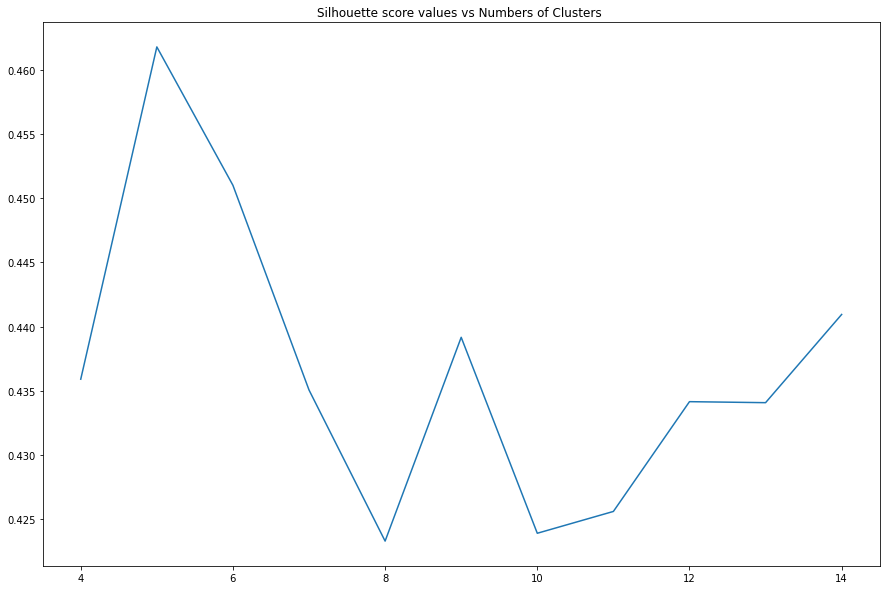

Optimal number of components is:  5


In [14]:
# Determine the best k value for the kmeans analysis. 
fig_kn = plt.figure(figsize=(15, 10))

obs = pg_ll_only.copy()
silhouette_score_values = list()
number_of_clusters = range(4, 15)
for i in number_of_clusters:
        classifier = KMeans(i, init='k-means++', n_init=10,
                            max_iter=300, tol=0.0001, random_state=10)
        classifier.fit(obs)
        labels = classifier.predict(obs)
        silhouette_score_values.append(sklearn.metrics.silhouette_score(
            obs, labels, metric='euclidean', random_state=0))

plt.plot(number_of_clusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()

optimum_k = number_of_clusters[silhouette_score_values.index(
     max(silhouette_score_values))]
print("Optimal number of components is: ", optimum_k)

fig_kn.savefig('k_means_k.jpg')

Now run the kmeans algorythm to find the centre points of each cluster. 

In [15]:
# set number of clusters as per the analysis above, 5 = optimum number. 
kclusters = 5

# run k-means clustering
k_means = KMeans(n_clusters=kclusters, random_state=0).fit(pg_ll_only)

# check cluster labels generated for each row in the dataframe
k_means_labels = k_means.labels_
#print(k_means_labels)

k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[149.06326453, -35.36003073],
       [149.05012703, -35.22477652],
       [149.12206904, -35.18173143],
       [149.14009747, -35.28298371],
       [149.09814754, -35.42487945]])

In [16]:
# Convert the array back into a dataframe for ease of use. 
clusters = pd.DataFrame(k_means_cluster_centers)

# Label columns and 
clusters.columns = ['Cluster_Long', 'Cluster_Lat']

print('The centre of each cluster using kmeans analysis is: \n \n', clusters, '\n')
clusters.dtypes

The centre of each cluster using kmeans analysis is: 
 
    Cluster_Long  Cluster_Lat
0    149.063265   -35.360031
1    149.050127   -35.224777
2    149.122069   -35.181731
3    149.140097   -35.282984
4    149.098148   -35.424879 



Cluster_Long    float64
Cluster_Lat     float64
dtype: object

Now lets show the data points and the kmeans cluster centres on a plot. 

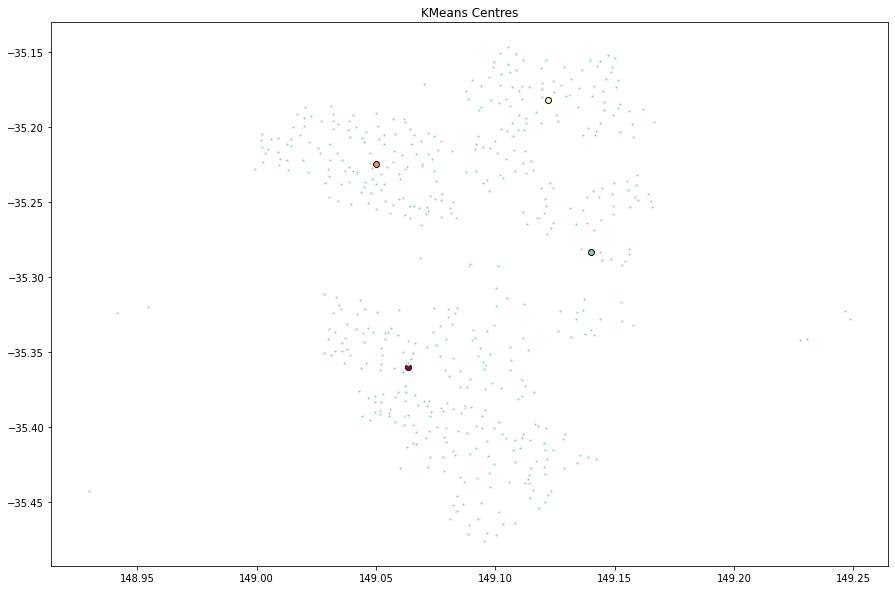

In [17]:
# initialize the plot with the specified dimensions.
fig_k = plt.figure(figsize=(15, 10))

# colors uses a color map, which will produce an array of colors based on
# the number of labels. We use set(k_means_labels) to get the
# unique labels.
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))

X = pd.DataFrame(pg_ll_only, columns = ['long','lat'])

# create a plot
ax = fig_k.add_subplot(1, 1, 1)

# loop through the data and plot the datapoints and centroids.
# k will range from 0-3, which will match the number of clusters in the dataset.
for k, col in zip(range(len([[4,4], [-2, -1], [2, -3], [1, 1]])), colors):
      
    # define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # plot the datapoints with color col.
    ax.plot([X.long], [X.lat], 'w', markerfacecolor=col, marker='.')
    
    # plot the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# title of the plot
ax.set_title('KMeans Centres')

# show the plot
plt.show()

#save to jpg file
fig_k.savefig('kmeans_plot.jpg')

# Map of Playgrounds and Cluster Centres

In [18]:
# Set the coordinates for the map to be built on. 

address_pg = 'Canberra, ACT'

geolocator = Nominatim(user_agent="ny_explorer")
location_pg = geolocator.geocode(address)
latitude_pg = location_pg.latitude
longitude_pg = location_pg.longitude
print('The geograpical coordinates of {} are {}, {}.'.format(address_pg, longitude_pg, latitude_pg))

The geograpical coordinates of Canberra, ACT are 149.1012676, -35.2975906.


In [19]:
# create map of Canberra using latitude and longitude values

map_pg = folium.Map(location=[latitude_pg, longitude_pg], zoom_start=11)

# add markers to map for individual playgrounds
for lat, lng, name in zip(pg_ll['lat'], pg_ll['long'], pg_ll['PARENT_PLA'],):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pg)  

# add markers to map for the k_means cluster centres
for lat_c, lng_c, in zip(clusters['Cluster_Lat'], clusters['Cluster_Long'],):
    label = '{}'.format("Cluster Centre")
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat_c, lng_c],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_pg)  

map_pg.save('map_clusters.html')

map_pg



#Extract Coffee Shop data for each Cluster:

Using the cluster centres as the lat/long we can loop thru each cluster and provide input to the Yelp API to get a list of the best Coffee Shops for each cluster. 

In [20]:
#create an empty list to store the results. 
shops_list = []

#Loop to use the cluster centre lat/long and Yelp API to return a result for the highest rated coffee shop in each cluster. 
n=1
for i in k_means_cluster_centers: 
    x = i[0]
    y = i[1]

    # Yelp API call to get results based on lat/long, coffee, 3000m radius and sort by rating.     
    response = yelp_api.search_query(term='coffee', 
                                          latitude = {y}, 
                                          longitude = {x},
                                          radius = 3000, 
                                          sort_by='rating', 
                                          limit=1)
    
    # ETL the data from JSON into a dataframe and clean
    shop_list_json = response['businesses']
    shop_list_df = pd.json_normalize(shop_list_json)
    shop_list_df = shop_list_df.rename(columns={'location.display_address': 'address', 'coordinates.latitude': 'Lat', 'coordinates.longitude': 'Long'})
        
    # Retreive the shop name and address. 
    shop_name = shop_list_df.name[0] 
    shop_loc = shop_list_df.address[0]
    lat = shop_list_df.Lat[0]
    long = shop_list_df.Long[0]
    details = (shop_name, shop_loc, lat, long)

    print('\nThe best Coffee Shop for Cluster {} is: {}' .format(n, details), '\n')
    
    # Save results to list for future use. 
    shops_list.append(details)

    n = n+1

#save the results to a txt file
textfile = open("shops_list.txt", "w")
for element in shops_list:
    textfile.write(str(element) + "\n")
textfile.close()



The best Coffee Shop for Cluster 1 is: ('Espresso Room', ['Bradley St', 'Canberra Australia Capital Territory 2606', 'Australia'], -35.34663, 149.08723) 


The best Coffee Shop for Cluster 2 is: ('Chatterbox Espresso Bar', ['40 Cameron Ave', 'Belconnen Australia Capital Territory 2617', 'Australia'], -35.241295, 149.070995) 


The best Coffee Shop for Cluster 3 is: ('G Tree', ['Shop 26', '30 Hibberson St', 'Gungahlin Australia Capital Territory 2912', 'Australia'], -35.185643, 149.1340176) 


The best Coffee Shop for Cluster 4 is: ('The Cupping Room', ['Shop 1', '#1', 'Canberra Australia Capital Territory 2601', 'Australia'], -35.280427, 149.125936) 


The best Coffee Shop for Cluster 5 is: ('Public Place @ Chishom', ['42 Halley St', 'Chisholm Australia Capital Territory 2905', 'Australia'], -35.41391, 149.12875) 



In [21]:
#Finally we can join the Coffee Shop details with the corresponding cluster for a complete data set. 

col_name = ['Coffee Shop Name', 'Address', 'Shop_Lat', 'Shop_Long']
shops_df = pd.DataFrame(shops_list, columns = col_name)

final = pd.concat([shops_df, clusters], axis=1)
final

#Save data to a csv file
final.to_csv('shop_df.csv')

#Final Map of all Data!

The individual playgrounds, cluster centres and the selected Coffee Shops can now all be plotted onto a single map. 

In [22]:
# create map of Canberra using latitude and longitude values

map_final = folium.Map(location=[latitude_pg, longitude_pg], zoom_start=11)

# add markers to map for individual playgrounds
for lat, lng, name in zip(pg_ll['lat'], pg_ll['long'], pg_ll['PARENT_PLA'],):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_final)  

# add markers to map for the k_means cluster centres
for lat_c, lng_c, in zip(clusters['Cluster_Lat'], clusters['Cluster_Long'],):
    label = '{}'.format("Cluster Centres")
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat_c, lng_c],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_final)  

# add markers to map for the highest rated Coffee Shop in the Cluster. 
for lat, lng, name, in zip(final['Shop_Lat'], final['Shop_Long'], final['Coffee Shop Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_final)

map_final.save('map_final.html')

map_final



# Thank you for reading my Project. 

# I hope you enjoyed your coffee! :)

# Thanks Bill. 